## MULTI-LAYER PERCEPTRON

In [91]:
# Allowed Libraries
import numpy as np
import matplotlib.pyplot as plt

import random
import math

# Multilayered Perceptron


The data is shuffled first and splitted to train and test data with split ratio 0.7. I visualized the data before trying to implement the MLP network. I designed a three layered network with one input, one hiddedn and one output layer. The input layer has two neuorons, hidden layer has five units with hyperbolic tangent activation function, and onutput layer has three units with sigmoid activation function. I used mean squared error function to calculate total error. I used a fixed learning rate and network has no momentum.

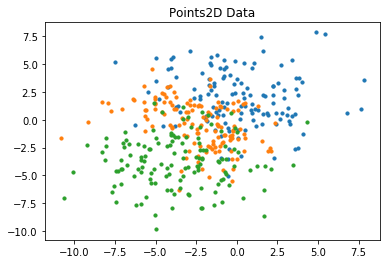

In [92]:
data = np.loadtxt("points2d.dat", dtype='d', delimiter=' ')

fig1  = plt.figure()
plt.title("Points2D Data")

plt.scatter(data[data[:, 2] == 0][:,0], data[data[:, 2] == 0][:,1], s=10)
plt.scatter(data[data[:, 2] == 1][:,0], data[data[:, 2] == 1][:,1], s=10)
plt.scatter(data[data[:, 2] == 2][:,0], data[data[:, 2] == 2][:,1], s=10)

#dividing the data to training and test.
np.random.shuffle(data)
train_data = data[0:int(len(data)*0.7)]
test_data = data[int(len(data)*0.7):]

I used object oriented approach to implement network. I firstly implemented Neuron class, this class have all the necessary functions and attributes. The bias and weights corresponds to incoming wieghts and bias. The error calculations of all the partial dericatives are here. You can see the respective functions and comments below.

In [93]:
class Neuron:
    def __init__(self, bias, isHidden=False):
        self.bias = bias
        self.weights = []
        self.isHidden = isHidden

    # the output from neuron which is squashed net input.
    def calculate_output(self, inputs):
        self.inputs = inputs
        self.output = self.squash(self.calculate_total_net_input())
        return self.output
    
    #returns the net inputs of the neuoron
    def calculate_total_net_input(self):
        total = 0
        for i in range(len(self.inputs)):
            total += self.inputs[i] * self.weights[i]
        return total + self.bias
    
    #calculates the output from activation functions. If the neouron is a member of the hidden layer, it uses hyperbolic tangent function, otherwise uses sigmoid.
    def squash(self, total_net_input):
        if self.isHidden:
            return math.tanh(total_net_input)
        return 1 / (1 + math.exp(-total_net_input))

    # calculates the derivative of error respects to net input
    def d_error_net(self, target_output):
        return self.d_error_output(target_output) * self.d_total_net_input();
    
    #mean squared error
    def calculate_error(self, target_output):
        return 0.5 * (target_output - self.output) ** 2

    # calculates the derivative of error respects to output
    def d_error_output(self, target_output):
        return -(target_output - self.output)
    #calculates the derivative of total net input respects to net input. The main difference between hidden layer and 
    def d_total_net_input(self):
        if self.isHidden:
            return 1-self.output*self.output
        return self.output * (1 - self.output)
    
    #calculates the derivative of total net input respects to net weights
    def d_total_weight(self, index):
        return self.inputs[index]


The second classs is NeuronLayer. This layer represents the layers of network, it just wraps the neurons and calls their functions together for ease of use.

In [94]:
class NeuronLayer:
    def __init__(self, num_neurons, isHidden=False):
        self.bias = random.random()
        self.isHidden = isHidden
        self.neurons = []
        for i in range(num_neurons):
            self.neurons.append(Neuron(self.bias, isHidden))
            
    #feed forward of the layer, just calls the neorons' function.
    def feed_forward(self, inputs):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.calculate_output(inputs))
        return outputs
    
    #returns outputs of the layer. 
    def get_outputs(self):
        outputs = []
        for neuron in self.neurons:
            outputs.append(neuron.output)
        return outputs

The last class is neural network. The main class is this. It usess layer and neuron classes to generate a network. You can set fixed learning rate in the above parameter. Currently it is set to 0.3, after some trials I found this one as ideal for my network.

In [95]:
class NeuralNetwork:
    LEARNING_RATE = 0.3

    def __init__(self, num_inputs, num_hidden, num_outputs):
        self.num_inputs = num_inputs

        self.hidden_layer = NeuronLayer(num_hidden, isHidden=True)
        self.output_layer = NeuronLayer(num_outputs, isHidden=False)

        self.init_weights_of_hidden()
        self.init_weights_of_output()
    #initilizes randomly the weights from input to hidden layer
    def init_weights_of_hidden(self):
        weight_num = 0
        for h in range(len(self.hidden_layer.neurons)):
            for i in range(self.num_inputs):
                self.hidden_layer.neurons[h].weights.append(random.random())
                weight_num += 1
    #initilizes randomly the weights from hidden to output layer
    def init_weights_of_output(self):
        weight_num = 0
        for o in range(len(self.output_layer.neurons)):
            for h in range(len(self.hidden_layer.neurons)):
                self.output_layer.neurons[o].weights.append(random.random())
                weight_num += 1

    #feed forward of all network.
    def feed_forward(self, inputs):
        hidden_layer_outputs = self.hidden_layer.feed_forward(inputs)
        return self.output_layer.feed_forward(hidden_layer_outputs)

    #trains the network, firstly it feeds forward and after that calculates deltas with backpropagtion and updates the weights. 
    def train(self, training_inputs, training_outputs):
        self.feed_forward(training_inputs)
        
        #partial derivative of errors respect to total net input of output layer
        d_errors_total = [0] * len(self.output_layer.neurons)
        for o in range(len(self.output_layer.neurons)):
            d_errors_total[o] = self.output_layer.neurons[o].d_error_net(training_outputs[o])

        #partial derivative of errors respect to total net input of hidden layer
        d_errors_total_hidden = [0] * len(self.hidden_layer.neurons)
        for h in range(len(self.hidden_layer.neurons)):
            d_error_wrt_hidden_neuron_output = 0
            for o in range(len(self.output_layer.neurons)):
                d_error_wrt_hidden_neuron_output += d_errors_total[o] * self.output_layer.neurons[o].weights[h]
            d_errors_total_hidden[h] = d_error_wrt_hidden_neuron_output * self.hidden_layer.neurons[h].d_total_net_input()

        for o in range(len(self.output_layer.neurons)):
            for w_ho in range(len(self.output_layer.neurons[o].weights)):
                #partial derivative of errors respect to output weights
                d_error_weight = d_errors_total[o] * self.output_layer.neurons[o].d_total_weight(w_ho)

                self.output_layer.neurons[o].weights[w_ho] -= self.LEARNING_RATE * d_error_weight

        for h in range(len(self.hidden_layer.neurons)):
            for w_ih in range(len(self.hidden_layer.neurons[h].weights)):

                d_error_weight = d_errors_total_hidden[h] * self.hidden_layer.neurons[h].d_total_weight(w_ih)

                self.hidden_layer.neurons[h].weights[w_ih] -= self.LEARNING_RATE * d_error_weight
    # getting the errors and summing them. Returns the total error for given set.
    def calculate_total_error(self, training_sets):
        total_error = 0
        for t in range(len(training_sets)):
            training_inputs, training_outputs = training_sets[t]
            self.feed_forward(training_inputs)
            for o in range(len(training_outputs)):
                total_error += self.output_layer.neurons[o].calculate_error(training_outputs[o])
        return total_error

This part initializes the neural network. Firstly gets the one hot encoding of the classes.

In [96]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

X = train_data[:,[0,1]]
X_test = test_data[:,[0,1]]
y_test =[]
y = []
for e in train_data[:,2]:
    if e == 0:
        y.append([1,0,0])
    elif e ==1:
        y.append([0,1,0])
    else:
        y.append([0,0,1])
y = np.array(y)

for e in test_data[:,2]:
    if e == 0:
        y_test.append([1,0,0])
    elif e ==1:
        y_test.append([0,1,0])
    else:
        y_test.append([0,0,1])

y_test = np.array(y_test)

training_sets = list(map(lambda x, t: [[x[0], x[1]],[t[0], t[1], t[2]]]  , X, y))
test_sets = list(map(lambda x, t: [[x[0], x[1]],[t[0], t[1], t[2]]]  , X_test, y_test))
nn = NeuralNetwork(2, 5, 3)

errors = []
i = 0
while(True):
    training_inputs, training_outputs = random.choice(training_sets)
    nn.train(training_inputs, training_outputs)
    error = nn.calculate_total_error(training_sets)
    print(i,error)
    errors.append(error)
    i+=1
    if i<100:
        continue
    #if training does not improve stop the training
    if error > sum(errors[-20:-1])/len(errors[-20:-1]):
        break
        
        
total = 0
correct_classification = 0
last_set = []
for test_input, expected_output in test_sets:
    out = nn.feed_forward(test_input)
    if np.argmax(out) == np.argmax(expected_output):
        correct_classification+=1
    total+=1
    last_set.append(test_input+[np.argmax(out)])

0 147.3999548148957
1 144.1348847734715
2 142.98907682016974
3 140.62998054406958
4 139.12108115504432
5 137.1519312587287
6 135.29124528422102
7 132.51631891060612
8 130.47595203090793
9 130.49088758432677
10 128.10027712172015
11 125.82534672693014
12 125.51433688633999
13 124.80537996975997
14 126.09672094203476
15 126.90118396821674
16 125.23978183333405
17 124.8239858206304
18 122.34032297281591
19 122.8492752681638
20 120.87198409541077
21 118.62158802446847
22 116.53315652318898
23 116.10346131826147
24 115.50218367660496
25 114.89893162573729
26 113.17023516525435
27 112.39656752337959
28 111.48863870174763
29 111.2542620494305
30 111.22524316229479
31 112.33653314137159
32 109.98842955370401
33 109.7543250957863
34 108.99074656459385
35 109.83727527906112
36 108.34993901076069
37 107.57155288508541
38 108.15381403658293
39 107.11471903786146
40 107.14611745092724
41 103.51292748591085
42 103.39569593285593
43 103.87906701303616
44 102.52231709233541
45 103.23606010253827
46 10

Accuracy : 0.6833333333333333


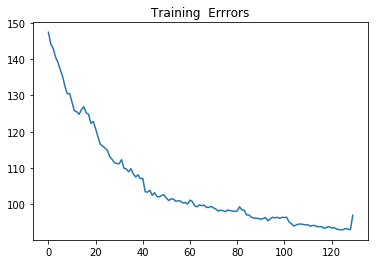

In [97]:
print("Accuracy :" , correct_classification/total)
plt.title("Training  Errrors")
plt.plot(range(len(errors)), errors) 

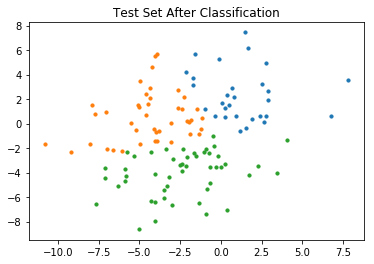

In [98]:
fig1  = plt.figure()
plt.title("Test Set After Classification")
last_set = np.array(last_set)
plt.scatter(last_set[last_set[:, 2] == 0][:,0], last_set[last_set[:, 2] == 0][:,1], s=10)
plt.scatter(last_set[last_set[:, 2] == 1][:,0], last_set[last_set[:, 2] == 1][:,1], s=10)
plt.scatter(last_set[last_set[:, 2] == 2][:,0], last_set[last_set[:, 2] == 2][:,1], s=10)


The statisctics for each class 

green : TPs
blue : TNs
orange : FPs,
red: FNs


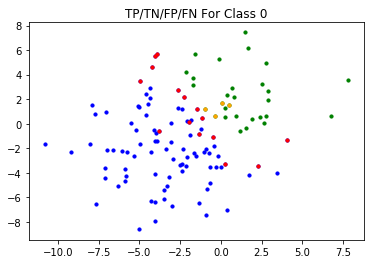

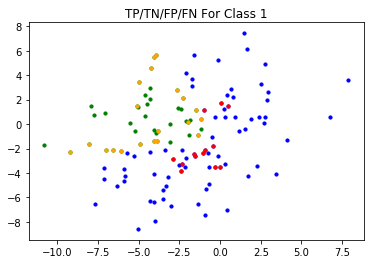

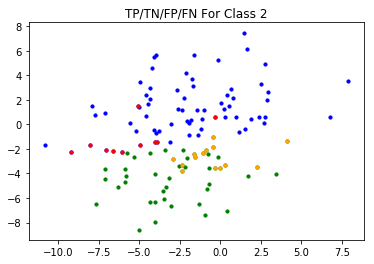

In [99]:
print("green : TPs\nblue : TNs\norange : FPs,\nred: FNs")

for i in range(3):
    tp0s = []
    for x in last_set[last_set[:, 2] == i]:
        if x in test_data[test_data[:,2] == i]:
            tp0s.append(x)
    tp0s=np.array(tp0s)

    tn0s = []
    for x in last_set[last_set[:, 2] != i]:
        if x in test_data[test_data[:,2] != i]:
            tn0s.append(x)
    tn0s = np.array(tn0s)

    fp0s = []
    for x in last_set[last_set[:, 2] == i]:
        if x in test_data[test_data[:,2] != i]:
            fp0s.append(x)
    fp0s = np.array(fp0s)

    fn0s = []
    for x in last_set[last_set[:, 2] != i]:
        if x in test_data[test_data[:,2] == i]:
            fn0s.append(x)
    fn0s = np.array(fn0s)
    fig1  = plt.figure()
    plt.title("TP/TN/FP/FN For Class " + str(i))
    if tp0s.size != 0:
        plt.scatter(tp0s[:,0],tp0s[:,1], s=10, c="green")
    if tn0s.size != 0:
        plt.scatter(tn0s[:,0],tn0s[:,1], s=10, c="blue")
    if fp0s.size != 0:
        plt.scatter(fp0s[:,0],fp0s[:,1], s=10, c="orange")
    if fn0s.size != 0:
        plt.scatter(fn0s[:,0],fn0s[:,1], s=10, c="red")
